# PYSPARK MASTER CLASS


### Introduction 
 Apache spark is a powerful open source engine that provides real-time stream processing, interactive processing, graph processing, in-memory processing as well as batch processing with very fast speed, ease of use and standard interface.

### Architecture 
https://jaceklaskowski.gitbooks.io/mastering-apache-spark/content/spark-architecture.html

### Data for this example
related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict whether the client will subscribe (Yes/No) to a term deposit. The dataset can be downloaded from Kaggle.


In [88]:
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('bank.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



Input variables: age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome.

Output variable: ** deposit **



In [54]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [55]:
df.groupBy('deposit').count().show()


+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



#### Summary Statistics
Lets get some numeric statistis for our data


In [56]:
df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('deposit', 'string')]

In [57]:
numeric_features = [feature[0] for feature in df.dtypes if feature[1] in 'int']

In [58]:
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


#### Get Correlations between the variables
Correlations between independent variables.

/Users/s6803068/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  This is separate from the ipykernel package so we can avoid doing imports until


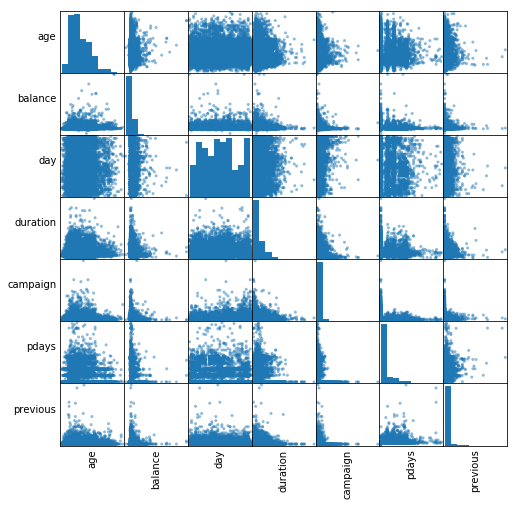

In [59]:
%matplotlib inline
numeric_data = df.select(numeric_features).toPandas()
axs = pd.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [61]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()


root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



#### Preparing Data for Machine Learning
The process includes Category Indexing, One-Hot Encoding and VectorAssembler — a feature transformer that merges multiple columns into a vector column.

In [62]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

#### Pipeline

We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow.
A Pipeline’s stages are specified as an ordered array.



In [63]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [64]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1,1,1,1,1
features,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no


In [65]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7764
Test Dataset Count: 3398


### Logistic Regression


In [66]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

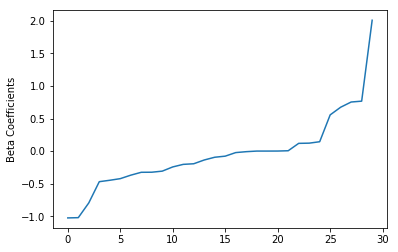

In [67]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

Summarize the model over the training set, we can also obtain the receiver-operating characteristic and areaUnderROC.

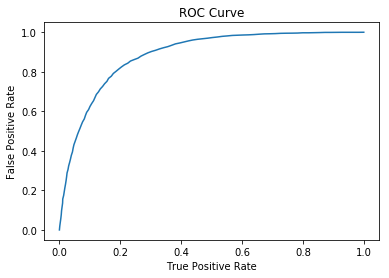

Training set areaUnderROC: 0.884909242115


In [68]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Precision and recall

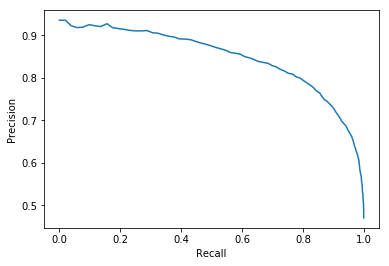

In [69]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [70]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 37|management|  0.0|[1.19871810716723...|       0.0|[0.76829666339830...|
| 40|management|  0.0|[2.20534940465796...|       0.0|[0.90072886169926...|
| 53|management|  0.0|[1.02590348276690...|       0.0|[0.73612093009497...|
| 32|management|  0.0|[1.25795481657702...|       0.0|[0.77867383994058...|
| 54|management|  0.0|[1.33232096924268...|       0.0|[0.79122429116078...|
| 40|management|  0.0|[1.57095096412779...|       0.0|[0.82791913346617...|
| 56|management|  0.0|[3.06095963426752...|       0.0|[0.95525333386804...|
| 50|management|  0.0|[-0.8102603273804...|       1.0|[0.30783502428597...|
| 47|management|  0.0|[0.67024288891379...|       0.0|[0.66155754396054...|
| 44|management|  0.0|[1.29756265761715...|       0.0|[0.78542449653716...|
+---+-------

### Evaluate our Logistic Regression model.

In [72]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

('Test Area Under ROC', 0.8858324614449619)


In [102]:
print "Model 1 was fit using parameters: "
lrModel.extractParamMap()
# lrModel.summary.truePositiveRateByLabel  # Explain differen
lrModel.summary?

Model 1 was fit using parameters: 


In [75]:
import lime
import lime.lime_tabular
# 
#  To  be completed later
#

###  Decision Tree Classifier

In [76]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 37|management|  0.0|[1130.0,387.0]|       0.0|[0.74489123269611...|
| 40|management|  0.0| [1333.0,86.0]|       0.0|[0.93939393939393...|
| 53|management|  0.0|[1130.0,387.0]|       0.0|[0.74489123269611...|
| 32|management|  0.0|[1130.0,387.0]|       0.0|[0.74489123269611...|
| 54|management|  0.0| [1333.0,86.0]|       0.0|[0.93939393939393...|
| 40|management|  0.0|  [373.0,30.0]|       0.0|[0.92555831265508...|
| 56|management|  0.0| [1333.0,86.0]|       0.0|[0.93939393939393...|
| 50|management|  0.0|[788.0,1230.0]|       1.0|[0.39048562933597...|
| 47|management|  0.0|[788.0,1230.0]|       1.0|[0.39048562933597...|
| 44|management|  0.0|[1130.0,387.0]|       0.0|[0.74489123269611...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

In [77]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.780724005007


### Gradient-Boosted Tree Classifier

In [78]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)

gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)



+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 37|management|  0.0|[0.57808138910181...|       0.0|[0.76063477260811...|
| 40|management|  0.0|[1.37467582901950...|       0.0|[0.93987672346171...|
| 53|management|  0.0|[-0.0012929624008...|       1.0|[0.49935351915983...|
| 32|management|  0.0|[0.61900313605401...|       0.0|[0.77521678642033...|
| 54|management|  0.0|[0.98157815641818...|       0.0|[0.87687413211579...|
| 40|management|  0.0|[0.96138354833170...|       0.0|[0.87244668327834...|
| 56|management|  0.0|[1.39120025731353...|       0.0|[0.94171733839668...|
| 50|management|  0.0|[-0.6141629093446...|       1.0|[0.22647458093662...|
| 47|management|  0.0|[-0.0439971283470...|       1.0|[0.47801561939801...|
| 44|management|  0.0|[0.26452511568224...|       0.0|[0.62926156628314...|
+---+-------

In [79]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.894072847315


In [80]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features)
labelCol: label column name. (default: label)
lossType: Loss function which GBT tries to minimize (case-insensitive). Supported options: logistic (default: logistic)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth: Maximum depth of the tree. (>= 0)

In [81]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8981050997838095

In [104]:
bestPipeline = cvModel.bestModel
#bestPipeline.trees
#bestLRModel = bestPipeline.stages[2]
#bestParams = bestLRModel.extractParamMap()
cvModel.bestModel.params

[Param(parent=u'GBTClassifier_4821ba34e4a1355215d9', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'),
 Param(parent=u'GBTClassifier_4821ba34e4a1355215d9', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'),
 Param(parent=u'GBTClassifier_4821ba34e4a1355215d9', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'),
 Param(parent=u'GBTClassifier_4821ba34e4a1355215d9', name='featuresCol', doc='features column name'),
 Param(parent=u'GBTClassifier_4821ba34e4a1355215d9', name='impurity', doc='Criterion

In [94]:
cvModel.avgMetrics

[0.8598737108095693,
 0.8748670166980805,
 0.8877351529823823,
 0.892430725958638,
 0.8872274828169477,
 0.8887470184959477,
 0.8607053945192338,
 0.8760895423048618,
 0.8892557269564382,
 0.8932040386008129,
 0.889913033830827,
 0.8928696554392157]